In [ ]:
! pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import lru_cache
from Levenshtein import distance as levenshtein_distance
from collections import defaultdict
import numpy as np

# Прочтение таблиц

In [ ]:
data = pd.read_csv("/content/Pavlina_Grey.tsv")
data.head()

,Rank\tRead.count\tRead.proportion\tCDR3.nucleotide.sequence\tCDR3.amino.acid.sequence\tbestVGene\tbestJGene
0,0\t2454\t0.00281746737926165\tTGTGCCAGCAGCAACA...
1,1\t1915\t0.0021986348945746\tTGTGCCACCAGTTCCGT...
2,2\t1369\t0.00157176562437213\tTGTGCCAGCAGTTCCC...
3,3\t1255\t0.00144088083169249\tTGTGCCAGCAGCTTAG...
4,4\t1152\t0.00132262527339422\tTGTGCCAGCAGCCGCC...


In [ ]:
df = pd.DataFrame(data)
df.columns = ['data']
df['CDR3.amino.acid.sequence'] = df['data'].str.split('\t').str[4]
df['Read.proportion'] = df['data'].str.split('\t').str[2]
df['Read.proportion'] = pd.to_numeric(df['Read.proportion'])
df['Read.count'] = df['data'].str.split('\t').str[1]
df['bestVGene'] = df['data'].str.split('\t').str[5]
df['bestJGene'] = df['data'].str.split('\t').str[6]
del df['data']
df

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene
0,CASSNSDRTYGDNEQFF,0.002817,2454,TRBV6-3,TRBJ2-1
1,CATSSVLTQQETQYF,0.002199,1915,TRBV24-1,TRBJ2-5
2,CASSSRGLANTQYF,0.001572,1369,TRBV12-4,TRBJ2-3
3,CASSLGTALNTEAFF,0.001441,1255,TRBV7-8,TRBJ1-1
4,CASSRRHLGNTGELFF,0.001323,1152,TRBV7-2,TRBJ2-2
...,...,...,...,...,...
624076,FGSSYQGNSNQPQHF,0.000001,1,TRBV6-5,TRBJ1-5
624077,FSSSVLTGNSNQPQHF,0.000001,1,TRBV12-3,TRBJ1-5
624078,FSSSYQGAHFSNQPQHF,0.000001,1,TRBV6-5,TRBJ1-5
624079,FSSSYSTGGGSTEAFF,0.000001,1,TRBV6-5,TRBJ1-1


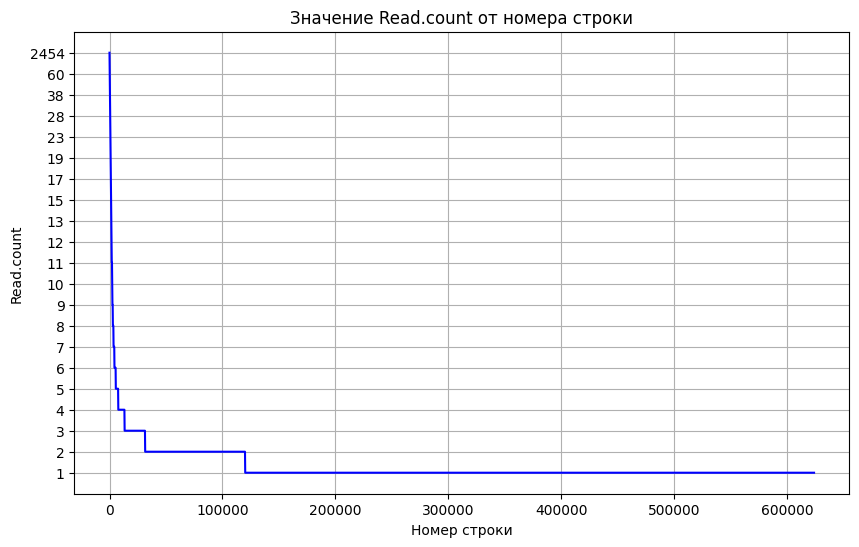

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[::200], df['Read.count'][::200], linestyle='-', color='b')
plt.xlabel('Номер строки')
plt.ylabel('Read.count')
plt.title('Значение Read.count от номера строки')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
index_30 = df[df['Read.count'] == '40'].index
print(index_30)

Index([361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
       375, 376, 377, 378],
      dtype='int64')


In [ ]:
database = pd.read_excel("/content/vdjdb_slim.xlsx")

In [ ]:
database_exp = database.rename(columns={'cdr3': 'CDR3.amino.acid.sequence'})

In [ ]:
data_claster = df[:361]
data_claster

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene
0,CASSNSDRTYGDNEQFF,0.002817,2454,TRBV6-3,TRBJ2-1
1,CATSSVLTQQETQYF,0.002199,1915,TRBV24-1,TRBJ2-5
2,CASSSRGLANTQYF,0.001572,1369,TRBV12-4,TRBJ2-3
3,CASSLGTALNTEAFF,0.001441,1255,TRBV7-8,TRBJ1-1
4,CASSRRHLGNTGELFF,0.001323,1152,TRBV7-2,TRBJ2-2
...,...,...,...,...,...
356,CASSLGGNEQFF,0.000047,41,TRBV7-3,TRBJ2-1
357,CASSLFGGEGETQYF,0.000047,41,TRBV5-5,TRBJ2-5
358,CASSEEVTGATEAFF,0.000047,41,TRBV6-1,TRBJ1-1
359,CAISAGFTLYNEQFF,0.000047,41,TRBV10-3,TRBJ2-1


# Функция кластеризации

In [ ]:
# Кэшированная функция для вычисления расстояния Левенштейна
@lru_cache(maxsize=None)
def cached_levenshtein_distance(seq1, seq2):
    return levenshtein_distance(seq1, seq2)

# Функция для кластеризации последовательностей
def cluster_sequences(sequences, max_distance=1):
    clusters = []
    for seq in sequences:
        added_to_cluster = False
        for cluster in clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for existing_seq in cluster):
                cluster.append(seq)
                added_to_cluster = True
                break
        if not added_to_cluster:
            clusters.append([seq])
    return clusters

# Функция для объединения кластеров
def merge_clusters(clusters, max_distance=1):
    merged_clusters = []
    for cluster in clusters:
        added_to_cluster = False
        for merged_cluster in merged_clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for seq in cluster for existing_seq in merged_cluster):
                merged_cluster.extend(cluster)
                added_to_cluster = True
                break
        if not added_to_cluster:
            merged_clusters.append(cluster)
    return merged_clusters

# Пример последовательностей аминокислот
sequences = data_claster['CDR3.amino.acid.sequence']

# Разделение данных на части
chunk_size = len(sequences) // 100
chunks = [sequences[i:i + chunk_size] for i in range(0, len(sequences), chunk_size)]

# Кластеризация каждой части
all_clusters = []
for chunk in chunks:
    all_clusters.extend(cluster_sequences(chunk, max_distance=1))

# Объединение кластеров
final_clusters = merge_clusters(all_clusters, max_distance=1)

# Вывод результатов
# Создание DataFrame
cluster_data = []
for i, cluster in enumerate(final_clusters):
    for seq in cluster:
        cluster_data.append({'Cluster': i + 1, 'Sequence': seq})

results_df = pd.DataFrame(cluster_data)

In [ ]:
# Создание нового DataFrame с данными из data_claster и номером кластера
cluster_assignments = {}
for i, cluster in enumerate(final_clusters):
  for seq in cluster:
    cluster_assignments[seq] = i + 1

results_df = data_claster.copy()
results_df['Cluster'] = results_df['CDR3.amino.acid.sequence'].map(cluster_assignments)

# Вывод нового DataFrame results_df
results_df


,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene,Cluster
0,CASSNSDRTYGDNEQFF,0.002817,2454,TRBV6-3,TRBJ2-1,1
1,CATSSVLTQQETQYF,0.002199,1915,TRBV24-1,TRBJ2-5,2
2,CASSSRGLANTQYF,0.001572,1369,TRBV12-4,TRBJ2-3,3
3,CASSLGTALNTEAFF,0.001441,1255,TRBV7-8,TRBJ1-1,4
4,CASSRRHLGNTGELFF,0.001323,1152,TRBV7-2,TRBJ2-2,5
...,...,...,...,...,...,...
356,CASSLGGNEQFF,0.000047,41,TRBV7-3,TRBJ2-1,349
357,CASSLFGGEGETQYF,0.000047,41,TRBV5-5,TRBJ2-5,350
358,CASSEEVTGATEAFF,0.000047,41,TRBV6-1,TRBJ1-1,351
359,CAISAGFTLYNEQFF,0.000047,41,TRBV10-3,TRBJ2-1,352


# Подсчёт Total Read Proportion

In [ ]:
# Подсчет суммарного Read.proportion для каждого кластера
cluster_proportions = {}
cluster_counts = {}
for index, row in data_claster.iterrows():
  seq = row['CDR3.amino.acid.sequence']
  proportion = row['Read.proportion']
  for i, cluster in enumerate(final_clusters):
    if seq in cluster:
      cluster_proportions[i + 1] = cluster_proportions.get(i + 1, 0) + proportion
      cluster_counts[i + 1] = cluster_counts.get(i + 1, 0) + 1
      break

# Создание DataFrame с суммарными пропорциями, номерами кластеров и количеством последовательностей
proportions_data = []
for cluster_number, total_proportion in cluster_proportions.items():
  proportions_data.append({'Cluster': cluster_number,
               'Total Read Proportion': total_proportion,
               'Sequence Count': cluster_counts[cluster_number]})



# Сортировка по Sequence Count

In [ ]:
proportions_df = pd.DataFrame(proportions_data)
proportions_df = proportions_df.sort_values(by='Sequence Count', ascending=False)
proportions_df

,Cluster,Total Read Proportion,Sequence Count
110,111,0.000217,3
60,61,0.000304,3
113,114,0.000176,2
212,213,0.000116,2
210,211,0.000115,2
...,...,...,...
119,120,0.000091,1
118,119,0.000092,1
117,118,0.000093,1
116,117,0.000093,1


# Сортировка по Total Read Proportion

In [ ]:
proportions_df_sorted = proportions_df.sort_values(by='Total Read Proportion', ascending=False)
proportions_df_sorted = proportions_df_sorted.loc[proportions_df_sorted['Sequence Count'] > 1]
proportions_df_sorted

,Cluster,Total Read Proportion,Sequence Count
60,61,0.000304,3
110,111,0.000217,3
100,101,0.000193,2
113,114,0.000176,2
212,213,0.000116,2
210,211,0.000115,2


# Выбор кластера

In [ ]:
full = pd.merge(results_df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,55,CASSLDTDTQYF,0.000165,TRBV7-2,TRBJ2-3,TRBV7-9*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,BMLF1
1,55,CASSLDTDTQYF,0.000165,TRBV7-2,TRBJ2-3,TRBV5-1*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,pp65
2,88,CASSLSGNTEAFF,0.000119,TRBV7-9,TRBJ1-1,TRBV27*01,TRBJ1-1*01,MHCI,HomoSapiens,InfluenzaA,M
3,88,CASSLSGNTEAFF,0.000119,TRBV7-9,TRBJ1-1,TRBV7-9*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
4,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,LMP2A
5,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
6,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
7,292,CASSQDLAGGTDTQYF,0.000053,TRBV4-2,TRBJ2-3,TRBV4-2*01,TRBJ2-3*01,MHCI,HomoSapiens,Mtb,Rv1734c
8,300,CASSLGGAAYNEQFF,0.000052,TRBV5-1,TRBJ2-1,TRBV7-3*01,TRBJ2-1*01,MHCI,HomoSapiens,YFV,NS4B
9,309,CASSLVNTEAFF,0.000051,TRBV5-1,TRBJ1-1,TRBV11-2*01,TRBJ1-1*01,MHCII,HomoSapiens,HomoSapiens,p53


In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])]
full_vj

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
3,88,CASSLSGNTEAFF,0.000119,TRBV7-9,TRBJ1-1,TRBV7-9*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
4,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,LMP2A
5,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
6,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
7,292,CASSQDLAGGTDTQYF,0.000053,TRBV4-2,TRBJ2-3,TRBV4-2*01,TRBJ2-3*01,MHCI,HomoSapiens,Mtb,Rv1734c
10,319,CSVGTGGTNEKLFF,0.000049,TRBV29-1,TRBJ1-4,TRBV29-1*01,TRBJ1-4*01,MHCI,HomoSapiens,EBV,BMLF1
11,319,CSVGTGGTNEKLFF,0.000049,TRBV29-1,TRBJ1-4,TRBV29-1*01,TRBJ1-4*01,MHCII,HomoSapiens,InfluenzaA,NP


In [ ]:
full_vj['Cluster'].value_counts()

,count
Cluster,
114,3
319,2
88,1
292,1


# Обработка для одного выбранного кластера

In [ ]:
results_df_one_cluster = results_df.loc[results_df['Cluster'] == 114]
results_df_one_cluster = results_df_one_cluster.rename(columns={'Sequence': 'CDR3.amino.acid.sequence'})
results_df_one_cluster

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene,Cluster
114,CASSEDGNTEAFF,0.000094,82,TRBV6-4,TRBJ1-1,114
147,CASSEDGMNTEAFF,0.000082,71,TRBV10-2,TRBJ1-1,114


In [ ]:
full = pd.merge(results_df_one_cluster, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,LMP2A
1,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
2,114,CASSEDGMNTEAFF,0.000082,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65


In [ ]:
full['antigen.gene'].value_counts()

,count
antigen.gene,
LMP2A,1
IE1,1
pp65,1
